# Linear Regression
In linear regression our predictors are linear functions $f : \R^d\to\R$ each parameterized by a vector $\bw\in\R^d$ real coefficients. That is, $f(\bx) = \bw^{\top}\bx$.

Given a training set $(\bx_1,y_1),\ldots,(\bx_m,y_m) \in \R^d\times\R$, the linear regression predictor is the Empirical Risk Minimizer with respect to the square loss,
$$
    \bwhat = \argmin_{\bw\in\R^d} \sum_{t=1}^m \big(\bw^{\top}\bx_t - y_t\big)^2
$$
Now let $\bv = \big(\bw^{\top}\bx_1,\ldots,\bw^{\top}\bx_m\big)$ and $\by = (y_1,\ldots,y_m)$. Then
$$
     \sum_{t=1}^m \big(\bw^{\top}\bx_t - y_t\big)^2 = \norm{\bv-\by}^2.
$$
Since $\bv = S\bw$, where $S$ is a $m \times d$ matrix such that $S^{\top} = [\bx_1,\ldots,\bx_m]$, we may also write
$$
    \bwhat = \argmin_{\bw\in\R^d} \norm{S\bw-\by}^2
$$
Since $F(\bw) = \norm{S\bw-\by}^2$ is a convex function, the minimizer satisfies the condition $\nabla F(\bw) = \bzero$.

Using matrix calculus, we have that $\nabla\norm{S\bw-\by}^2 = 2S^{\top}(S\bw-\by)$. Hence, $\nabla\norm{S\bw-\by}^2 = \bzero$ for $\bw = \big(S^{\top}S\big)^{-1}S^{\top}\by$ provided $S^{\top}S$ is invertible.

Therefore, whenever $S^{\top}S$ is invertible we have that $\bwhat = \big(S^{\top}S\big)^{-1}S^{\top}\by$.

Since the Bayes optimal predictor for square loss is $f(\bx) = \E[Y \mid \bx]$, the Bayes optimal predictor is a linear function when $y = \bu^{\top}\bx + \ve_{\bx}$, where $\ve_{\bx}$ is an independent random variable such that $\E[\ve_{\bx} \mid \bx] = 0$.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import decomposition
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, validation_curve, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#from auxCode import *
%matplotlib inline

We start by using the function `make_regression()` to generate a random dataset on which the Bayes optimal predictor is a linear function. We set $d=1$, $m=1000$, and $\sqrt{\Var[\ve_{\bx} \mid \bx]} = 10$.

In [2]:
X, y, w = make_regression(n_samples=1000, n_features=1, n_informative=1, n_targets=1,
                          noise=10.0, shuffle=True, coef=True, random_state=42)

We can inspect the coefficient of the Bayes optimal predictor.

In [3]:
np.round(w.item(), decimals=2)

16.75

The Bayes risk is the squared conditional variance, averaged over data points. In our case, Bayes risk $(10)^2 = 100$.

If we compute it on our dataset we get something close but not quite the same, which is reasonable considering we have sampled just $1000$ data points.

In [4]:
y_opt = w.item()*X
np.round(mean_squared_error(y, y_opt), decimals=2)

98.03

Next, we split the dataset in train and test, with proportions 60% and 40%.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

We run a linear regression learner on the training data and print the learned coefficient.

In [6]:
learner = LinearRegression()
learner.fit(X_train, y_train)
np.round(learner.coef_[0], decimals=2)

16.93

Note that the learned linear regressor is pretty close to the coefficient $16.75$ of the Bayes optimal predictor.

We then compute test predictions and measure test error with respect to the square loss.

In [7]:
y_pred = learner.predict(X_test)
np.round(mean_squared_error(y_test, y_pred), decimals=2)

102.37

If we plot the test points and the two linear regressors (the one we learned and the Bayes optimal one) we can get an idea of how good is linear regression when the Bayes optimal predictor is also a linear function.

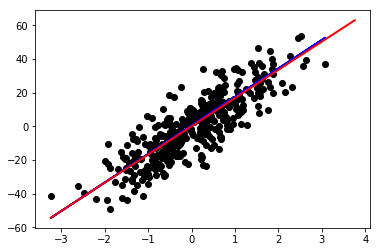

In [8]:
x_min = np.min(X)
x_max = np.max(X)
v = np.arange(x_min, x_max, 0.2)

plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=2)
plt.plot(v, v*w.item(), color='red', linewidth=2)
plt.show()

The test error of the Bayes optimal predictor is only slightly lower than that of the linear regressor learned on the training set.

In [9]:
y_opt = w.item()*X_test
np.round(mean_squared_error(y_test, y_opt), decimals=2)

101.31

Now we keep the same training set and change the labels to make the Bayes optimal predictor a nonlinear function of $x$, namely $y = \sin(x) + 0.3\ve_x$, where $\ve_x$ is an independent Gaussian random variable with zero mean and variance equal to $0.25$.

In [10]:
y = X * np.sin(X) + 0.5*np.random.randn(1000,1)

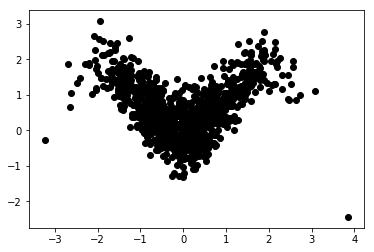

In [11]:
plt.scatter(X, y,  color='black')
plt.show()

If we train on the entire dataset, linear regression achieves a large training error.

In [12]:
learner.fit(X, y)
y_pred = learner.predict(X)
np.round(mean_squared_error(y, y_pred), decimals=2)

0.59

We now use a trick to make linear regression more powerful at the expense of increasing the number of features.

The function `PolynomialFeatures()` replaces the original features $\bx = (x_1,\ldots,x_d)$ with all polynomial combinations of features with degree less than or equal to a specified degree $n$. For instance, if $d=2$ and $n=2$, the original features $(x_1,x_2)$ are replaced by $(1,x_1,x_2,x_1x_2,x_1^2,x_2^2)$. Note that the number of new features is of order $d^n$.

With $n=5$ the training error of linear regression goes down a lot.

In [13]:
poly = PolynomialFeatures(degree=5, interaction_only=False, include_bias=True)
X_poly = poly.fit_transform(X)
learner.fit(X_poly, y)
y_pred = learner.predict(X_poly)

In [14]:
np.round(mean_squared_error(y, y_pred), decimals=2)

0.25

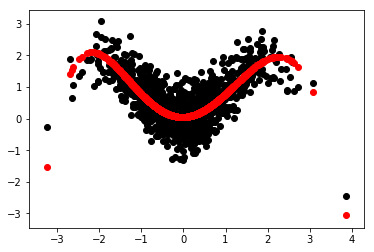

In [15]:
plt.scatter(X, y,  color='black')
plt.scatter(X, y_pred,  color='red')
plt.show()

We are now ready to try out linear regression on a real-world dataset.

The Boston Housing Dataset originates from the UCI Machine Learning Repository. The data was collected in $1978$ and each of the $506$ entries represent aggregated data about $14$ features for homes from various suburbs in Boston, Massachusetts. The label is the column `MEDV`.

We load the dataset and add column names. Note the the field separator in the file is whitespace instead of comma.

In [16]:
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
housing = pd.read_csv("Datasets/housing.csv", delim_whitespace=True, names=names)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null int64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(12), int64(2)
memory usage: 55.4 KB


In [17]:
housing.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677082   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.105710    8.707259  168.537116    2.164946   91.294864   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.025000    2.100175    4.000000  279.000000   17.400000  375.377500   
50%     77.500000    3.207450    5.000000  330.000000   19.050000  391.440000   
75%     94.075000    5.188425   24.000000  666.000000   20.200000  396.225000   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            LSTAT        MEDV  
count  506.000000  506.000000  
mean    12.653063   22.532806  
std      7.141062    9.197104  
min      1.730000    5.000000  
25%      6.950000   17.025000  
50%     11.360000   21.200000  
75%     16.955000   25.000000  
max     37.970000   50.000000

In [18]:
housing.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

We take a look at the distribution of the labels using the `distplot()` function of Seaborn.

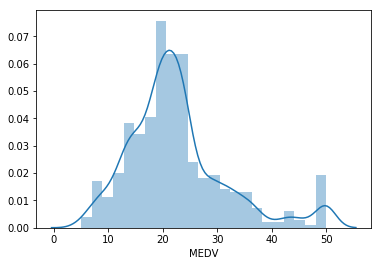

<Figure size 432x288 with 0 Axes>

In [19]:
sns.distplot(housing['MEDV']);
fig = plt.figure()

We also look at the correlation matrix between features. The DataFrame method `corr()` of Pandas computes the Pearson correlation coefficient of the sample, defined for each pair $i,j$ of features by
$$
    r_{i,j} = \frac{\sum_{t=1}^m (x_{i,t}-\mu_i)(x_{j,t}-\mu_j)}{\sqrt{\sum_{t=1}^m (x_{i,t}-\mu_i)^2}\sqrt{\sum_{t=1}^m (x_{j,t}-\mu_j)^2}}
$$
where $\mu_i = (x_{i,1}+\cdots+x_{i,m})/m$.

Recall that the Pearson correlation coefficient $r_{i,j}$ is always in the $[-1,+1]$ interval. Values of $r_{i,j}$ closer to the extremes indicate that $i$ and $j$ tend to be linearly correlated, whereas values of $r_{i,j}$ close to zero indicate that $i$ and $j$ are nearly independent.

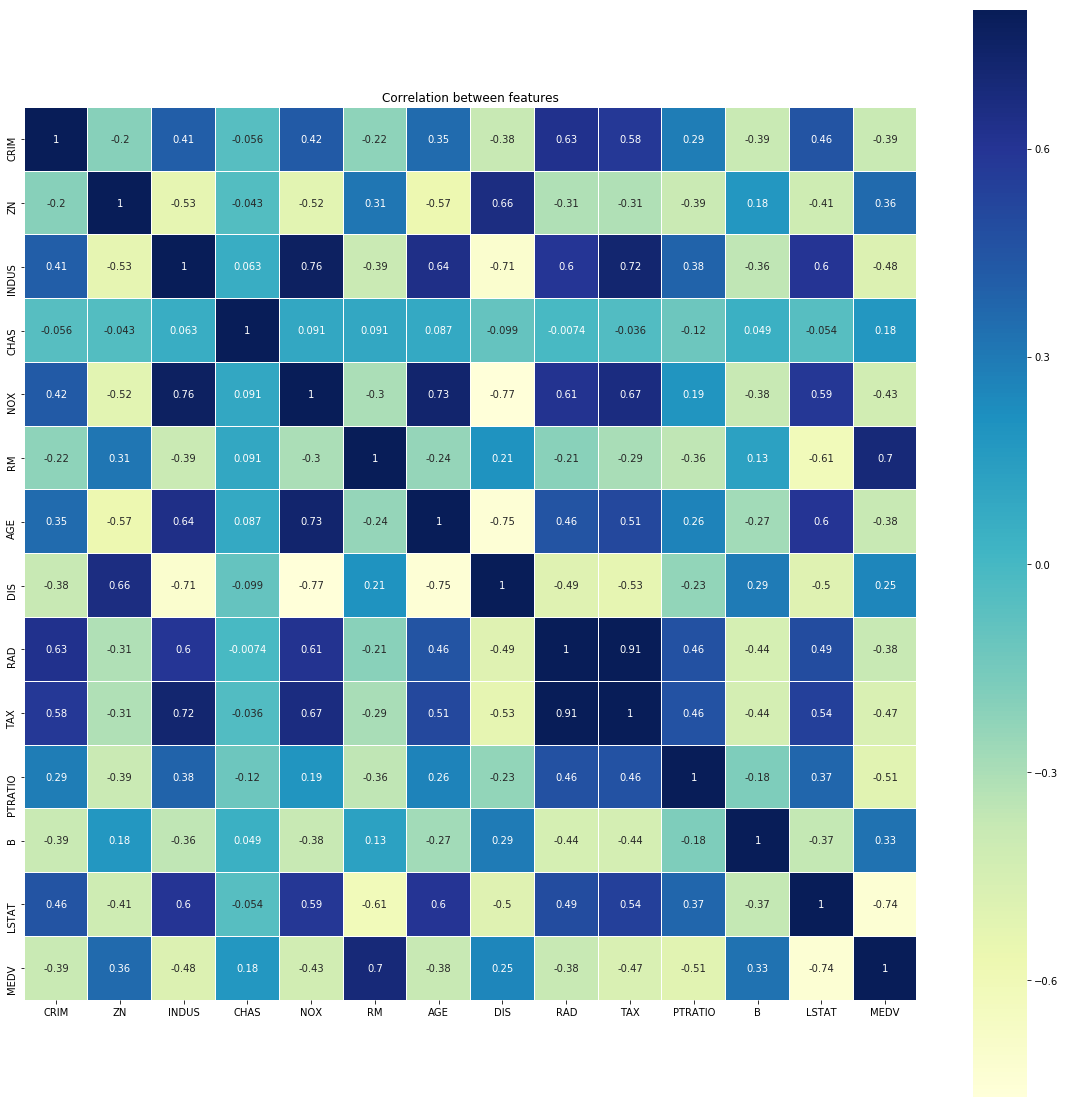

In [20]:
corr=housing.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

Pairs of features with correlation coefficient close to $-1$ or $+1$ are redundant (for example, `TAX` and `RAD` in this dataset), and we could only keep one for each pair.

We check which feature has a correlation larger than $0.75$ in absolute value with at least some other feature.

In [21]:
corr[((corr > 0.75) | (corr < -0.75)) & (corr != 1.0)].dropna(axis='index', how='all')

CRIM  ZN     INDUS  CHAS       NOX  RM  AGE      DIS       RAD  \
INDUS   NaN NaN       NaN   NaN  0.763651 NaN  NaN      NaN       NaN   
NOX     NaN NaN  0.763651   NaN       NaN NaN  NaN -0.76923       NaN   
DIS     NaN NaN       NaN   NaN -0.769230 NaN  NaN      NaN       NaN   
RAD     NaN NaN       NaN   NaN       NaN NaN  NaN      NaN       NaN   
TAX     NaN NaN       NaN   NaN       NaN NaN  NaN      NaN  0.910228   

            TAX  PTRATIO   B  LSTAT  MEDV  
INDUS       NaN      NaN NaN    NaN   NaN  
NOX         NaN      NaN NaN    NaN   NaN  
DIS         NaN      NaN NaN    NaN   NaN  
RAD    0.910228      NaN NaN    NaN   NaN  
TAX         NaN      NaN NaN    NaN   NaN

It turns out that we can safely drop `NOX` and `RAD`.

In [22]:
X = housing.drop(columns=['NOX', 'RAD', 'MEDV']).values
y = housing['MEDV'].values

We now set the linear regression learner with the (negative) square loss as scoring function. In our experiments, use the setting `normalize=True` which applies the data transformation $\bx_t \to (\bx_t - \bmu)/\norm{\bx_t}$ where $\bmu$ is the average of the data points.

In [23]:
learner = LinearRegression(normalize=True)
RMS = 'neg_mean_squared_error'

The cross-validated risk estimate is $34.77$

In [24]:
scores = cross_val_score(learner, X, y, cv=5, scoring=RMS)
np.round(-scores.mean(), decimals=2)

34.77

We now look at the learning curve for training set values from $150$ to $300$

In [25]:
sizes = range(150, 301, 25)
train_size, train_score, val_score = learning_curve(learner, X, y, train_sizes=sizes, cv=5, scoring=RMS)

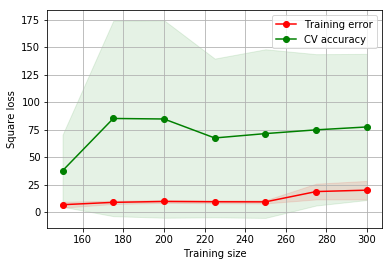

In [26]:
train_score_mean = -np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = -np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(sizes, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(sizes, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(sizes, train_score_mean, 'o-', color="r",
         label="Training error")
plt.plot(sizes, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Square loss')
plt.show()

Linear regression look **unstable** here. The risk estimates oscillate between $40$ and $80$ and have a huge variance. 

We repeat the experiment without cross-validation so that we can extract the linear model $\bwhat$ learned by linear regression for each training set size

In [27]:
coef_list = []

for s in range(150, 301, 25):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=s, random_state=42)
    learner.fit(X_train, y_train)
    coef_list.append(learner.coef_)

coef_matrix = np.array(coef_list)

/home/nicolo/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Then, we use PCA to visually check how different the learned models are.

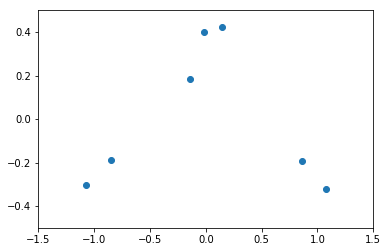

In [28]:
pca = decomposition.PCA(n_components=2)
pca.fit(coef_matrix)
coef_pca = pca.transform(coef_matrix)

fig, ax = plt.subplots()
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-0.5, 0.5)
plt.scatter(coef_pca[:,0], coef_pca[:,1])

In order to increase the stability of linear regression, we first use PCA to reduce the number of features and increase the bias.

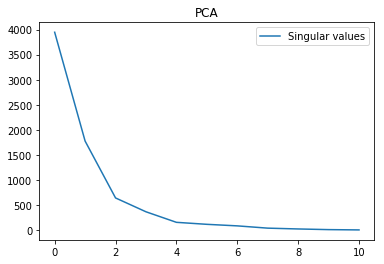

In [29]:
pca = decomposition.PCA(n_components=11)
pca.fit(X)

plt.title('PCA')
plt.plot(pca.singular_values_, label='Singular values')
plt.legend()
plt.show()

We project all the datapoints on the six principal components. Then we check the learning curve again.

In [30]:
pca = decomposition.PCA(n_components=6)
pca.fit(X)
X_pca = pca.transform(X)

In [31]:
sizes = range(150, 301, 25)
train_size, train_score, val_score = learning_curve(learner, X_pca, y, train_sizes=sizes, cv=5, scoring=RMS)

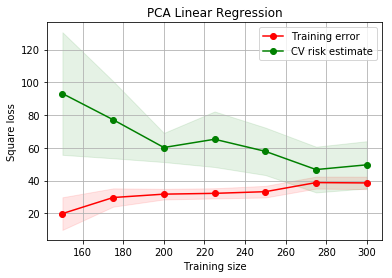

In [32]:
plt.title('PCA Linear Regression')
train_score_mean = -np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = -np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(sizes, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(sizes, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(sizes, train_score_mean, 'o-', color="r",
         label="Training error")
plt.plot(sizes, val_score_mean, 'o-', color="g",
         label="CV risk estimate")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Square loss')
plt.show()

The learning curve looks more stable now. We doublecheck by repeating the procedure to plot the spread of the vectors learned using increasing sizes of the training set.

In [33]:
coef_list = []

for s in range(150, 301, 25):
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=s, random_state=42)
    learner.fit(X_train, y_train)
    coef_list.append(learner.coef_)
coef_matrix = np.array(coef_list)

pca = decomposition.PCA(n_components=2)
pca.fit(coef_matrix)
coef_pca = pca.transform(coef_matrix)

/home/nicolo/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


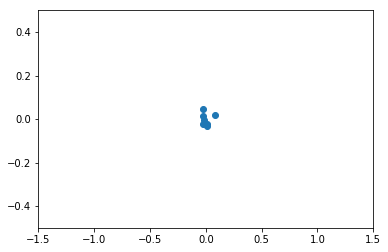

In [34]:
fig, ax = plt.subplots()
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-0.5, 0.5)
plt.scatter(coef_pca[:,0], coef_pca[:,1])

As the plot shows, the learned models are a indeed more stable after PCA.

## Ridge Regression

A better way to increase the bias in linear regression, and thus make the model more stable, is by introducing a regularizer in the ERM functional.

In other words, instead defining $\bwhat$ by
$$
    \bwhat = \argmin_{\bw\in\R^d} \norm{S\bw-\by}^2
$$
we use the regularized form, also known as *Ridge Regression*,
$$
    \bwhat = \argmin_{\bw\in\R^d} \norm{S\bw-\by}^2 + \alpha\norm{\bw}^2
$$
where $\alpha \ge 0$ is the regularization parameter. When $\alpha$ is zero we recover the standard linear regression solution. When $\alpha$ is very large, the solution $\bwhat$ becomes the zero vector. Hence $\alpha$ can be used to control the bias of the algorithm.

Similarly to before, we have that
$$
    \nabla\Big(\norm{S\bw-\by}^2 + \alpha\norm{\bw}^2\Big) = 2S^{\top}(S\bw-\by) + 2\alpha\bw
$$    
Hence, the gradient vanishes for $\bw = \big(\alpha I + S^{\top}S\big)^{-1}S^{\top}\by$. Note that we do not have to worry anymore about the invertibility of $S^{\top}S$. Indeed, if $\lambda_1 \ge\cdots\ge \lambda_d \ge 0$ are the eigenvalues of $S^{\top}S$, the eigenvalues of $\alpha I + S^{\top}S$ are simply
$
    \alpha+\lambda_1 \ge\cdots\ge \alpha+\lambda_d > 0
$. Hence, $\alpha I + S^{\top}S$ is invertible whenever $\alpha > 0$.

We start by investigating the sensitivity of the CV risk estimate to the choice of $\alpha$.

In [35]:
alpha_vals = np.linspace(0.01,2.0,20)
train_score, val_score = validation_curve(Ridge(normalize=True), X, y, 'alpha', alpha_vals, cv=5, scoring=RMS)

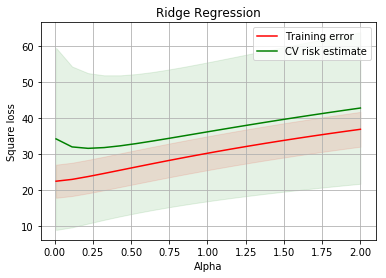

In [36]:
plt.title('Ridge Regression')
train_score_mean = -np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = -np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(alpha_vals, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(alpha_vals, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(alpha_vals, train_score_mean, color="r",
         label="Training error")
plt.plot(alpha_vals, val_score_mean, color="g",
         label="CV risk estimate")
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Square loss')
plt.show()

We see that overfitting essentially disappears for $\alpha > 0.5$, and bias progressively increases. The variance of the CV risk estimate remains high though.

With normalized data (as performed by the flag `normalize=True`), the choice $\alpha = 1$ is often reasonable.

We now compare the learning curves of PCA Linear Regression and Ridge Regression.

In [37]:
lin_reg = LinearRegression(normalize=True)

sizes = range(150, 301, 25)
l_train_size, l_train_score, l_val_score = learning_curve(lin_reg,
                                                          X_pca, y, train_sizes=sizes, cv=5, scoring=RMS)
r_train_size, r_train_score, r_val_score = learning_curve(Ridge(normalize=True),
                                                          X_pca, y, train_sizes=sizes, cv=5, scoring=RMS)

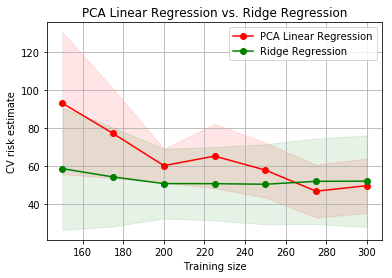

In [38]:
plt.title('PCA Linear Regression vs. Ridge Regression')
l_val_score_mean = -np.mean(l_val_score, axis=1)
l_val_score_std = np.std(l_val_score, axis=1)
r_val_score_mean = -np.mean(r_val_score, axis=1)
r_val_score_std = np.std(r_val_score, axis=1)
plt.grid()
plt.fill_between(sizes, l_val_score_mean - l_val_score_std,
                 l_val_score_mean + l_val_score_std, alpha=0.1,
                 color="r")
plt.fill_between(sizes, r_val_score_mean - r_val_score_std,
                 r_val_score_mean + r_val_score_std, alpha=0.1, color="g")
plt.plot(sizes, l_val_score_mean, 'o-', color="r",
         label="PCA Linear Regression")
plt.plot(sizes, r_val_score_mean, 'o-', color="g",
         label="Ridge Regression")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('CV risk estimate')
plt.show()

We see that, despite a large variance in the CV risk estimate, Ridge Regression is better than PCA Linear Regression, especially in the small training set regime.